In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import mixture
from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.data_sets.shape_net import pc_loader as sn_pc_loader


from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, sample_pclouds_distances
from tf_lab.point_clouds.gan import model_saver_id
from tf_lab.autopredictors.exploration import find_neighbors
from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from bench_pc_gan.evaluate_gan import entropy_of_occupancy_grid

PyTorch not working. MMD measurement won't be available


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA'
syn_id = shape_net_category_to_synth_id()['chair']
n_pc_samples = 2048

In [5]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [7]:
# Prepare random variable for JSD measuremnts.
voxel_resolution = 28
cmp_in_sphere = True
pclouds_ = pclouds_centered_and_half_sphere(pclouds)
_, gt_grid_var = entropy_of_occupancy_grid(pclouds_, voxel_resolution, in_sphere=cmp_in_sphere)

In [6]:
def invert_dictionary(d):
    inv_map = {v: k for k, v in d.iteritems()}
    return inv_map

def load_ae(ae_net_dir, load_epoch):
    ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
    reset_tf_graph()
    ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)
    bneck = ae.bottleneck_size
    print 'Bneck =', bneck 
    ae.restore_model(ae_net_dir, load_epoch, verbose=True)
    return ae, ae_conf

In [7]:
from tf_lab.icml.ae_farm_helper import EMD_Stats as exp_stats
bneck_to_experiment_id = invert_dictionary(exp_stats.experiment_id_to_bneck)

In [94]:
bneck = 4
exp = 18
ae_net_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/ae_farming/ae_farm_chair_conv_arch_'\
                 + str(exp) + '_2048pts_emd/'
load_epoch, _ = exp_stats.best_epochs[bneck]
ae, ae_conf = load_ae(ae_net_dir, load_epoch)
# Convert raw-data to latent codes.
raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
_, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)

Bneck = 4
Model restored in epoch 1000.


16
59199.1227451
59199.1227451
59199.1227451


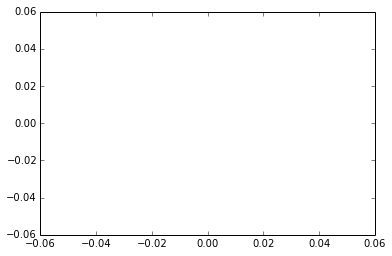

In [114]:
cov_type = 'full'
aic_scores = []
bic_scores = []
likelihood_scores = []

for n_component in [16]:
    print n_component
#     np.random.seed(0)
    gmm = mixture.GaussianMixture(n_component, covariance_type=cov_type)
    gmm.fit(latent_codes)
    sample_codes = gmm.sample(raw_data.num_examples)[0]
    print gmm.bic(latent_codes)    
    
    
#     sample_pcs = ae.decode(sample_codes)
#     aic_scores.append(gmm.aic(latent_codes))
#     bic_scores.append(gmm.bic(latent_codes))
#     print bic_scores
#     sample_codes = gmm.sample(raw_data.num_examples)[0]

    
    sample_codes = gmm.sample(raw_data.num_examples)[0]
    print gmm.bic(latent_codes)
    
    sample_codes = gmm.sample(raw_data.num_examples)[0]
    print gmm.bic(latent_codes)

#     likelihood_scores.append(gmm.score(latent_codes))
    
plt.plot(bic_scores, '*')

In [98]:
latent_codes.shape

(6778, 4)

In [35]:
for bneck, exp in bneck_to_experiment_id.iteritems(): 
    ae_net_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/ae_farming/ae_farm_chair_conv_arch_'\
                 + str(exp) + '_2048pts_emd/'
    load_epoch, _ = exp_stats.best_epochs[bneck]
    ae, ae_conf = load_ae(ae_net_dir, load_epoch)
    # Convert raw-data to latent codes.
    raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
    _, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)
    
    for cov_type in ['full', 'diag']:        
        print 'covariance_type =', cov_type
        # Fit a Gaussian Mixture Model with n_components - compute jsd
        np.random.seed(0)
        for n_component in [1, 2, 4, 10, 20]:
            gmm = mixture.GaussianMixture(n_component, covariance_type=cov_type)
            gmm.fit(latent_codes)
            sample_codes = gmm.sample(raw_data.num_examples)[0]
            sample_pcs = ae.decode(sample_codes)
            sample_pcs_ = pclouds_centered_and_half_sphere(sample_pcs)
            _, sample_grid_var = entropy_of_occupancy_grid(sample_pcs_, voxel_resolution, in_sphere=cmp_in_sphere)
            print 'n_components=%d JSD=%f' % (n_component, jensen_shannon_divergence(sample_grid_var, gt_grid_var))

    print ('\n')

Bneck = 128
Model restored in epoch 990.
covariance_type = full
n_components=1 JSD=0.012765
n_components=2 JSD=0.007745


/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


n_components=4 JSD=0.006202
n_components=10 JSD=0.003932
n_components=20 JSD=0.003328
covariance_type = diag
n_components=1 JSD=0.062583
n_components=2 JSD=0.034868
n_components=4 JSD=0.025091
n_components=10 JSD=0.018585
n_components=20 JSD=0.012488


Bneck = 64
Model restored in epoch 940.
covariance_type = full
n_components=1 JSD=0.013829
n_components=2 JSD=0.007856
n_components=4 JSD=0.006042
n_components=10 JSD=0.003629
n_components=20 JSD=0.003238
covariance_type = diag
n_components=1 JSD=0.042900
n_components=2 JSD=0.028176
n_components=4 JSD=0.020399
n_components=10 JSD=0.013471
n_components=20 JSD=0.009775


Bneck = 4
Model restored in epoch 1000.
covariance_type = full
n_components=1 JSD=0.026572
n_components=2 JSD=0.013027
n_components=4 JSD=0.010139
n_components=10 JSD=0.007907
n_components=20 JSD=0.005599
covariance_type = diag
n_components=1 JSD=0.028135
n_components=2 JSD=0.013554
n_components=4 JSD=0.009995
n_components=10 JSD=0.007516
n_components=20 JSD=0.005942


Bne